D:\Anaconda\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
D:\Anaconda\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 57 116 117 118 119 124 125 126 127] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\Anaconda\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Original number of features: 128
Number of features after selection: 40
Number of principal components: 12
Data identical after SQL round-trip? True
[LightGBM] [Info] Number of positive: 3092, number of negative: 3000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 6092, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Best Parameters: {'colsample_bytree': 1.0, 'max_depth': 20, 'min_child_samples': 2, 'n_estimators': 200, 'num_leaves': 63}
Accuracy: 0.9457
Precision: 0.9639
Recall: 0.9664
F1 Score: 0.9652
ROC AUC: 0.9739

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88       220
           1       0.

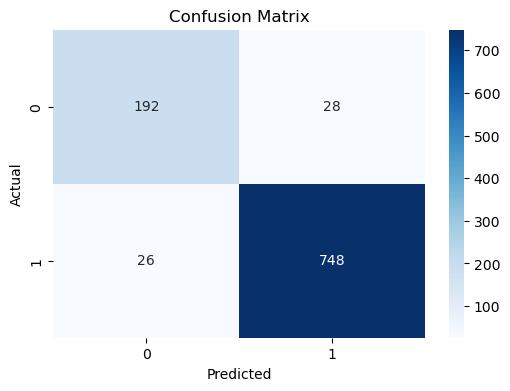

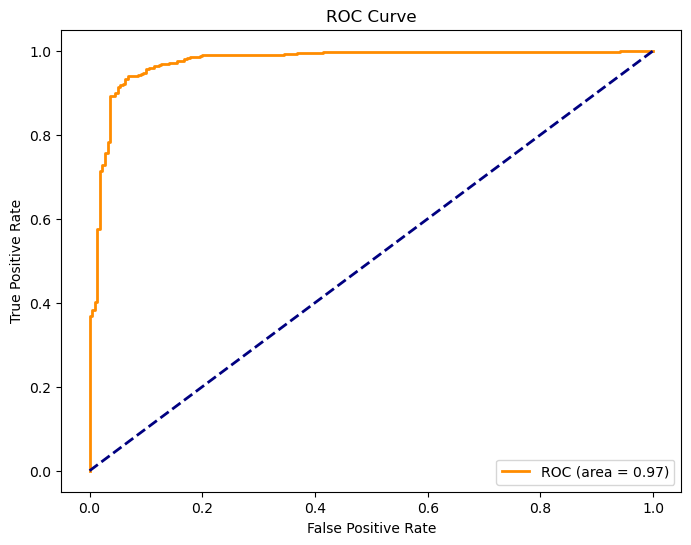

[LightGBM] [Info] Number of positive: 3092, number of negative: 880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 3972, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3093, number of negative: 880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 3973, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Numb

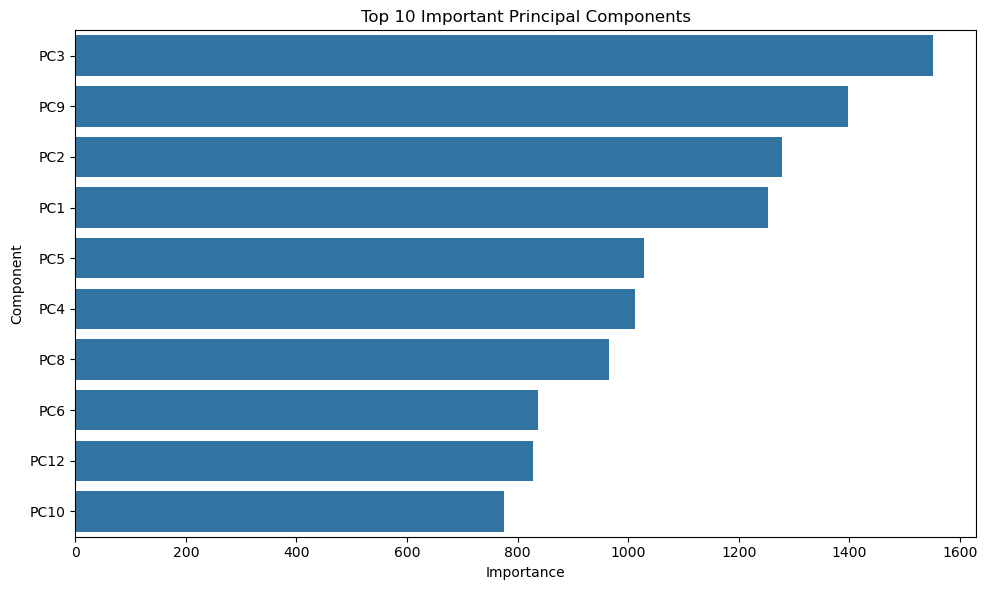

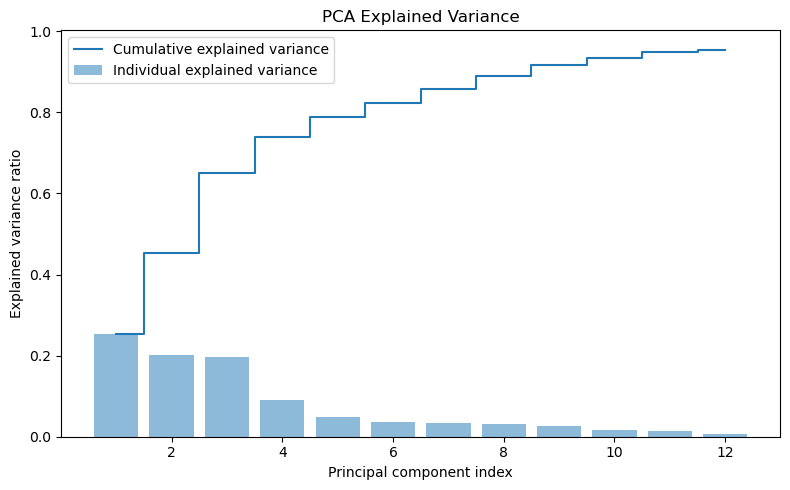

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, precision_score, 
                             recall_score, f1_score, roc_curve, auc)
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectKBest, f_classif
from sqlalchemy import create_engine, text

# ---------- SQL Integration Setup ----------
engine = create_engine("sqlite:///processed_data.db")  # SQLite database

# ---------- Load & Preprocess Data ----------
# Load data from GitHub
github_url = "https://raw.githubusercontent.com/haxshita/Power_Grid_Efficiency_Prediction/main/data/data1.csv" 
df = pd.read_csv(github_url)

y = np.where(df.iloc[:, -1] == 'Natural', 0, 1)
X = df.iloc[:, :-1]

X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

# ---------- Save Original Data to SQL ----------
df['Target'] = y  # add numeric target for reference
df.to_sql("original_data", con=engine, if_exists="replace", index=False)

# ---------- Transform & Select Features ----------
transformer = PowerTransformer(method='yeo-johnson')
X_transformed = transformer.fit_transform(X)

selector = SelectKBest(f_classif, k=40)
X_selected = selector.fit_transform(X_transformed, y)

# ---------- PCA ----------
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_selected)

print(f"Original number of features: {X.shape[1]}")
print(f"Number of features after selection: {X_selected.shape[1]}")
print(f"Number of principal components: {X_pca.shape[1]}")

# ---------- Save PCA Data to SQL (with correct types) ----------
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
X_pca_df['Target'] = y
X_pca_df = X_pca_df.astype({col: 'float64' for col in X_pca_df.columns if col != 'Target'})
X_pca_df.to_sql("pca_data", con=engine, if_exists="replace", index=False)

# ---------- Read Back & Validate ----------
read_data = pd.read_sql("SELECT * FROM pca_data", con=engine)
X_pca_from_sql = read_data.drop('Target', axis=1).values.astype(np.float64)
y_from_sql = read_data['Target'].values.astype(np.int64)

print("Data identical after SQL round-trip?", np.allclose(X_pca, X_pca_from_sql, atol=1e-6))

# ---------- Train-Test Split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_from_sql, y_from_sql, test_size=0.2, stratify=y_from_sql, random_state=42
)

# ---------- Oversampling ----------
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

# ---------- LightGBM GridSearch ----------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, -1],
    'min_child_samples': [2, 5],
    'num_leaves': [31, 63],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
lgbm = LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_res, y_res)

# ---------- Evaluate ----------
best_lgbm = grid_search.best_estimator_
y_pred = best_lgbm.predict(X_test)
y_proba = best_lgbm.predict_proba(X_test)[:, 1]

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------- ROC Curve ----------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# ---------- Cross Validation ----------
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}
cv_results = cross_validate(best_lgbm, X_pca_from_sql, y_from_sql, cv=5, scoring=scoring)

print("\nCross-Validation Results:")
for metric in scoring:
    print(f"{metric.capitalize()}: {cv_results[f'test_{metric}'].mean():.4f} ± {cv_results[f'test_{metric}'].std():.4f}")

# ---------- Feature Importance ----------
importances = best_lgbm.feature_importances_
important_components = pd.DataFrame({
    'Component': [f"PC{i+1}" for i in range(len(importances))],
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Component', data=important_components.head(10))
plt.title("Top 10 Important Principal Components")
plt.tight_layout()
plt.show()

# ---------- PCA Explained Variance ----------
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_,
        alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_),
         where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.title('PCA Explained Variance')
plt.tight_layout()
plt.show()